# Tabular data

In this tutorial, we will show how you can access tabular data in the form of ROOT TTrees from julia.

In [1]:
using ROOT, ROOTDataFrames, DataFrames, HEP, Histograms, ROOTHistograms

First, we download the tutorial data files if they don't already exist. We use the data files from the excellent open data tutorial of the CMS experiment: http://ippog.web.cern.ch/resources/2012/cms-hep-tutorial.

In [2]:
if !isdir("HEPTutorial")
    download("http://ippog.web.cern.ch/sites/ippog.web.cern.ch/files/HEPTutorial_0.tar", "HEPTutorial_0.tar")
    run(`tar xf HEPTutorial_0.tar`)
end

Check out what data sets are provided.

In [3]:
run(`ls HEPTutorial/files`)

data.root
dy.root
qcd.root
single_top.root
ttbar.root
wjets.root
ww.root
wz.root
zz.root


We create a data table from the file. Note that the data is not loaded to memory, but accessed from disk when the need arises.

In [4]:
df = TreeDataFrame(["HEPTutorial/files/data.root"]; treename="events");

Let us inspect the contents of the data. We are given the Eltype (data type) of a branch. The size column indicates whether a branch is scalar (size=1), a vector with fixed size (size>1) or a dynamic vector indexed by another branch (size=string).

In [5]:
show(STDOUT, df)

469384x51 ROOTDataFrames.TreeDataFrame{ROOTDataFrames.##RowData#7759}
| Col # | Name                        | Eltype           | sizes     |
|-------|-----------------------------|------------------|-----------|
| 1     | NJet                        | Int32            | 1         |
| 2     | Jet_Px                      | Array{Float32,1} | NJet      |
| 3     | Jet_Py                      | Array{Float32,1} | NJet      |
| 4     | Jet_Pz                      | Array{Float32,1} | NJet      |
| 5     | Jet_E                       | Array{Float32,1} | NJet      |
| 6     | Jet_btag                    | Array{Float32,1} | NJet      |
| 7     | Jet_ID                      | Array{Bool,1}    | NJet      |
| 8     | NMuon                       | Int32            | 1         |
| 9     | Muon_Px                     | Array{Float32,1} | NMuon     |
| 10    | Muon_Py                     | Array{Float32,1} | NMuon     |
| 11    | Muon_Pz                     | Array{Float32,1} | NMuon     |
| 12   

Using the following syntax, we can load contents of branches directly to memory to perform analysis on them.

In [69]:
numJets = df[:NJet];
energies = df[:Jet_E];

We calculate the mean number of jets in two cases: all events and events with at least one jet.

In [70]:
mean(numJets), mean(numJets[numJets .> 0])

(0.2689524994460825,1.3492294209435052)

For example, we can manually count the number of events with specific jet multiplicities.

In [72]:
for njet=0:10
    numevents = count(x->x == njet, numJets)
    println("$numevents events with $njet jets")
end

375818 events with 0 jets
66967 events with 1 jets
21919 events with 2 jets
3643 events with 3 jets
770 events with 4 jets
195 events with 5 jets
57 events with 6 jets
12 events with 7 jets
1 events with 8 jets
1 events with 9 jets
1 events with 10 jets


We can also loop over all the events without loading them to memory at once.

In [73]:
#enable this to print out the event contents
doprint = false

#we create a histogram for the jet transverse momentum spectrum
hjet_pt = ErrorHistogram(linspace(0,500,101))

#and also a coarses 2D distribution of pt vs. eta
hjet_pt_eta = ErrorHistogram(linspace(0,500,21), linspace(-5,5,21))


#loop over all rows
for iev=1:nrow(df)
    #load this row to memory
    #we specify only the branches we need
    load_row(df, iev, [:NJet, :Jet_E, :Jet_Px, :Jet_Py, :Jet_Pz, :EventWeight])
    
    #in general, events may be weighted
    w = value(df.row.EventWeight)
    
    doprint && println("--- Event $iev w=$(round(w,2))")
    
    #load the jet kinematics
    nj = df[iev, :NJet]
    jets_E = df[iev, :Jet_E]
    jets_px = df[iev, :Jet_Px]
    jets_py = df[iev, :Jet_Py]
    jets_pz = df[iev, :Jet_Pz]
    
    #create an emtpy list of four-momenta for the jets
    jet_p4 = Array(FourVector, nj)
    
    #loop over the jets to fill the four-momentum vectors
    for ijet=1:nj
        p4 = FourVector(jets_E[ijet], jets_px[ijet] ,jets_py[ijet], jets_pz[ijet])
        jet_p4[ijet] = p4
        m = round(HEP.l(p4), 2)
        pt = round(HEP.perp(p4), 2)
        eta = round(HEP.eta(p4), 2)
        phi = round(HEP.phi(p4), 2)
        
        doprint && println("Jet $ijet (m, pt, eta, phi) = ($m, $pt, $eta, $phi)")
        
        #fill the histogram
        push!(hjet_pt, pt, w)
        push!(hjet_pt_eta, (pt, eta), w)
    end
end

Now we would like to visualize the jet momentum spectra. ROOTHistograms.jl contains a definition of the visualization method `errorbar` for histograms.

In [74]:
using PyPlot
import PyPlot.errorbar

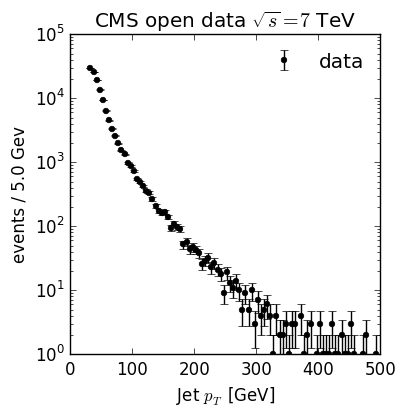

PyObject <matplotlib.legend.Legend object at 0x32bbbd8d0>

In [75]:
figure(figsize=(4,4))
errorbar(hjetpt, elinewidth=1, color="black", marker="o", label="data", linewidth=0, markersize=4.0)
yscale("log")
ylim(1.0, 100000)
xlabel("Jet \$p_T\$ [GeV]")

#we get the bin size from the histogram
binsize = round(diff(edges(hjetpt)[1])[1],2)
ylabel("events / $binsize Gev")

title("CMS open data \$\\sqrt{s}=7\$ TeV")
legend(frameon=false, numpoints=1)

In [76]:
using PyCall
@pyimport matplotlib.colors as mpl_colors

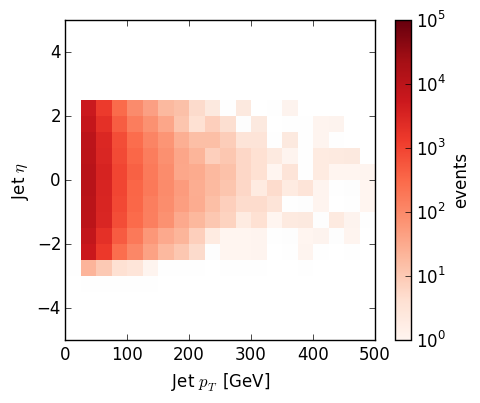

PyObject <matplotlib.text.Text object at 0x32bbff150>

In [77]:
figure(figsize=(5,4))
imshow(
    #transpose because otherwise 1st axis (x) is vertical as for matrices
    contents(hjet_pt_eta)|>transpose,
    cmap="Reds",
    #manually set axis range [xlow, xhigh, ylow, yhigh]
    extent=[0,500,-5,5],
    aspect="auto",
    interpolation="none",
    #log normalized z axis
    norm=mpl_colors.LogNorm(vmin=1.0, vmax=100000)
)
colorbar(label="events")
xlabel("Jet \$p_T\$ [GeV]")
ylabel("Jet \$\\eta\$")
